# Train a gesture recognizer

We start by installing pre-reqs. We use a TypeScript program to segment data (can be replaced in future).

In [63]:
! npm install -g -u typescript ts-node
! pip3 install -q tensorflow

/usr/local/bin/ts-node -> /usr/local/lib/node_modules/ts-node/dist/bin.jstiming action:finalizeK
/usr/local/bin/ts-script -> /usr/local/lib/node_modules/ts-node/dist/bin-script-deprecated.js
/usr/local/bin/ts-node-script -> /usr/local/lib/node_modules/ts-node/dist/bin-script.js
/usr/local/bin/ts-node-transpile-only -> /usr/local/lib/node_modules/ts-node/dist/bin-transpile.js
/usr/local/bin/tsc -> /usr/local/lib/node_modules/typescript/bin/tsc
/usr/local/bin/tsserver -> /usr/local/lib/node_modules/typescript/bin/tsserver
+ ts-node@9.0.0
+ typescript@4.0.3
updated 2 packages in 1.177s


Then we run the segmentation script.

In [64]:
! rm -rf built/
! ts-node segment.ts

loading data/michal/punch.csv
steady: [ 0.99609375, 0.04296875, 0.04296875 ]
cutoff: 0.453125 in cutoff %: 55.947136563876654
loading data/michal/right.csv
steady: [ 0.9375, 0.33203125, 0.0234375 ]
cutoff: 0.5703125 in cutoff %: 61.8100447538538
loading data/michal/left.csv
steady: [ 0.98828125, 0.01171875, 0.08984375 ]
cutoff: 0.4609375 in cutoff %: 63.18245450303313
loading data/michal/noise.csv
loading data/michal/noise1.csv
loading data/ira/punch2.csv
steady: [ 1.00390625, -0.08984375, 0.00390625 ]
cutoff: 1.2109375 in cutoff %: 67.358934169279
loading data/ira/right1.csv
steady: [ 0.97265625, 0.19140625, 0.21484375 ]
cutoff: 0.546875 in cutoff %: 63.898557931377425
loading data/ira/left0.csv
steady: [ 0.9765625, -0.15625, 0.22265625 ]
cutoff: 0.5625 in cutoff %: 58.14591332967636
loading data/ira/noise0.csv
median len: 30
len 50+: 1
data/michal/left.csv drop 1 too long
punch 11 13 10
right 16 19 15
left 15 17 14
noise 7 8 7
noise 19 22 18
punch 19 22 18
right 14 16 13
left 15 18 1

Here, we display the results of segmentation.

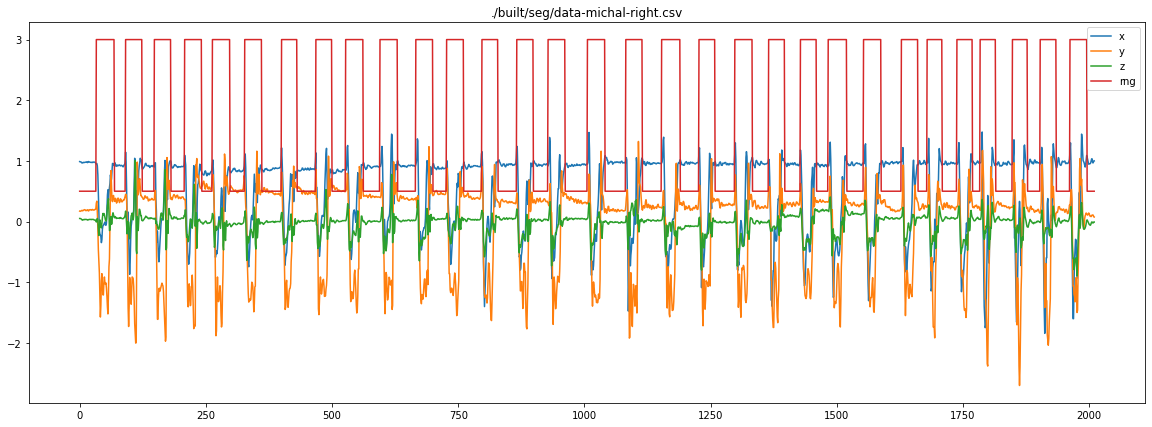

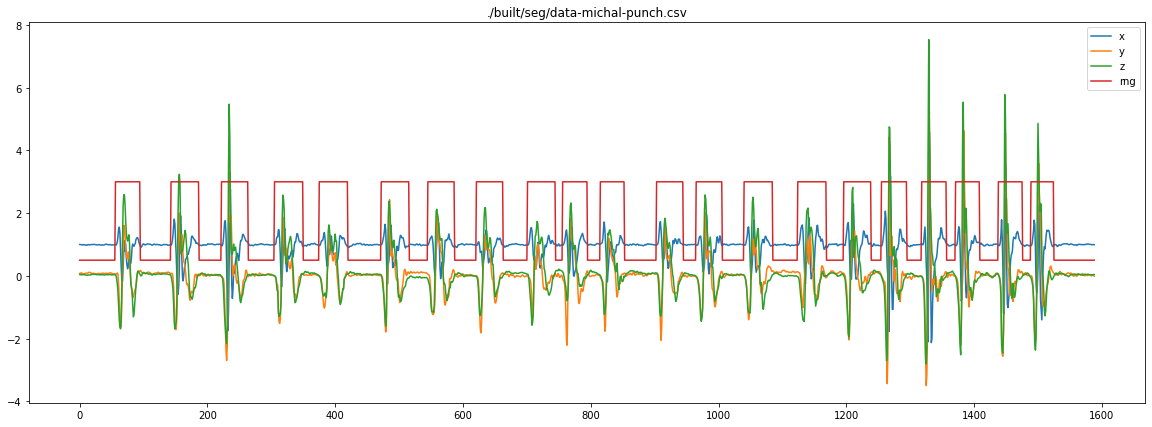

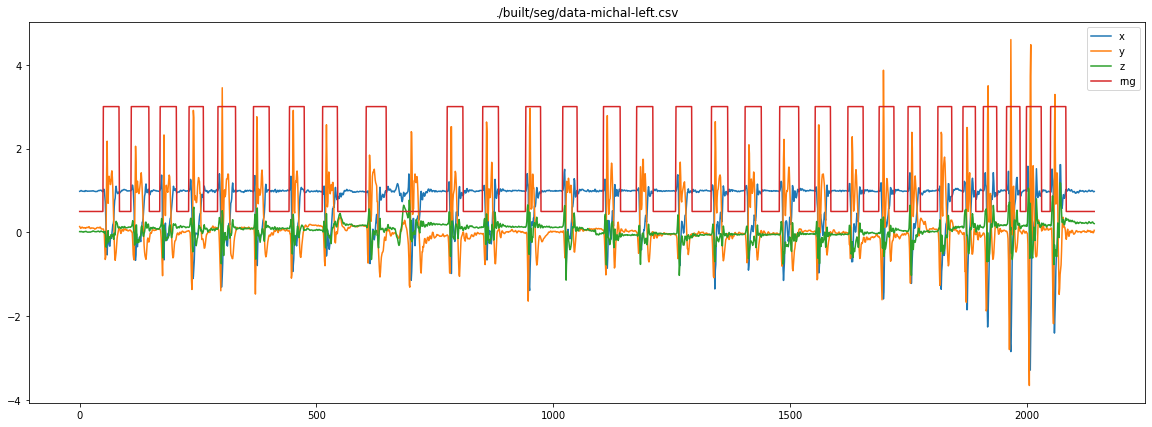

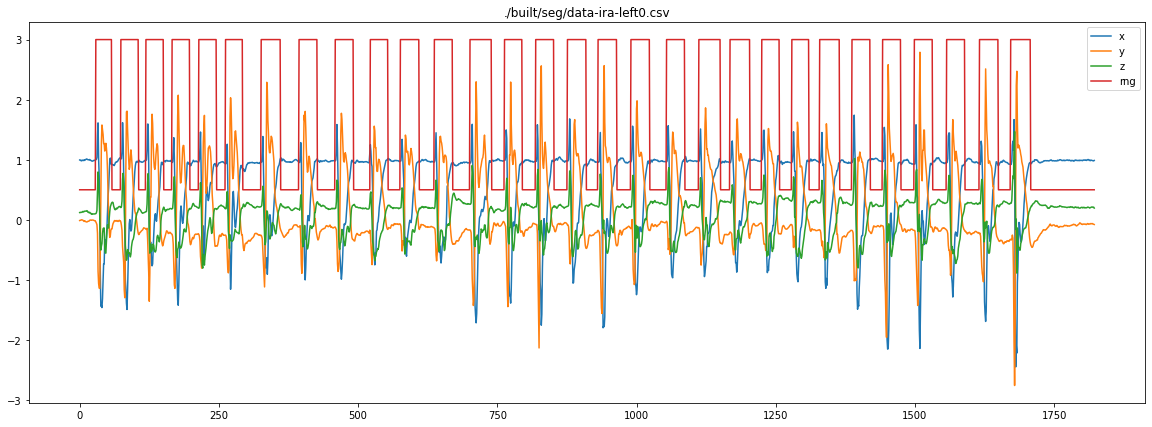

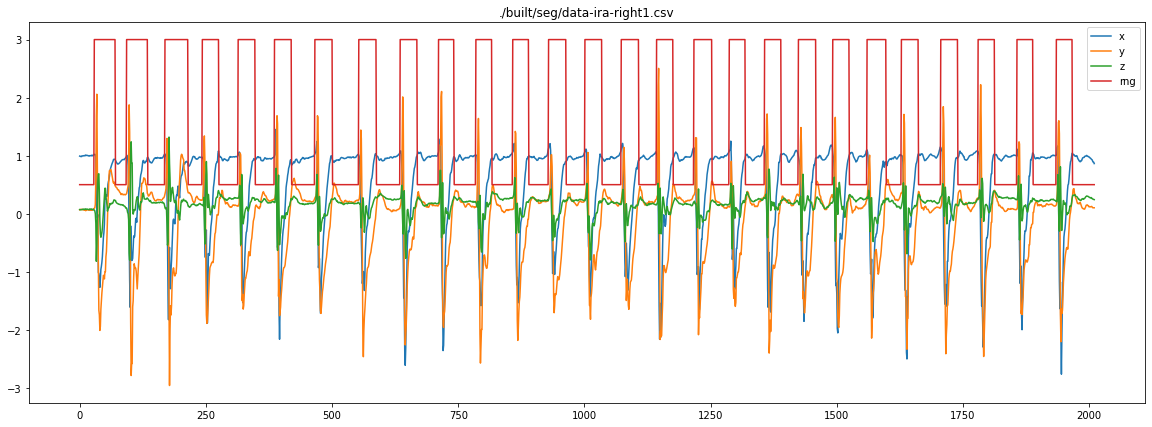

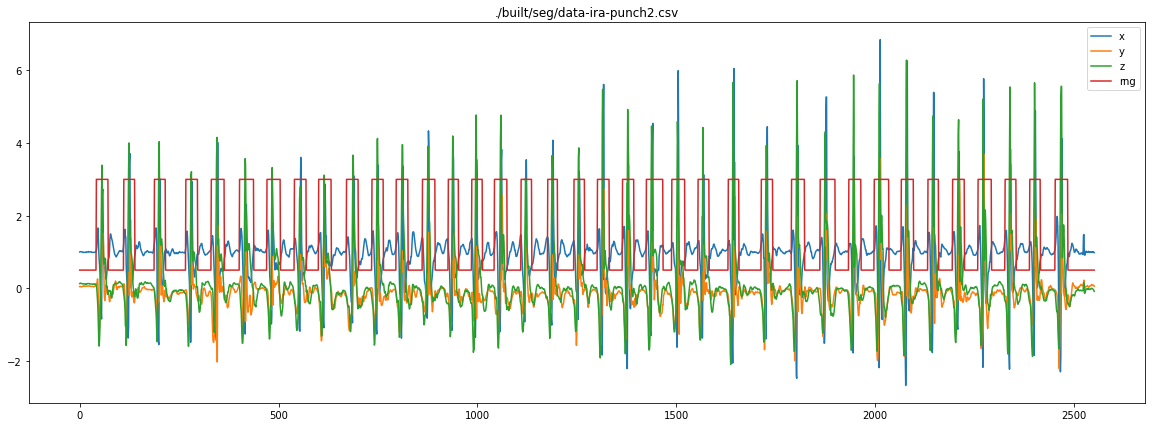

In [65]:
import pandas as pd
import matplotlib
import glob

for fn in glob.glob("./built/seg/*.csv"):
    data = pd.read_csv(fn)
    data.plot(figsize=(20,7),title=fn)


## Configure Defaults

In [66]:
# Define paths to model files
import os
# Set a "seed" value, so we get the same random numbers each time we run this
# notebook for reproducible results.
# Numpy is a math library
import numpy as np
np.random.seed(1) # numpy seed
# TensorFlow is an open source machine learning library
import tensorflow as tf
tf.random.set_seed(1) # tensorflow global random seed
# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math

Set Seed for Repeatable Results
## Load data to numpy

In [67]:
class_names = ['noise', 'punch', 'left', 'right']

def load_data(folder):
    x_tmp = []
    y_tmp = []
    for fn in glob.glob(folder + "/*.csv"):
        csv = pd.read_csv(fn)
        assert csv.values.shape == (50,3)
        x_tmp.append(csv.values.astype(np.float32))
        yy = [1 if class_names[i] in fn else 0 for i in range(len(class_names))]
        assert sum(yy) == 1
        y_tmp.append(yy)
    print("load %d samples from %s" % (len(y_tmp), folder))
    return np.array(x_tmp).reshape((-1,50,3,1)), np.array(y_tmp).astype(np.float32)

xs_train, ys_train = load_data("built/train")
xs_test, ys_test = load_data("built/test")
xs_validate, ys_validate = load_data("built/validate")

print(xs_train.shape, ys_train.shape)


load 1000 samples from built/train
load 500 samples from built/test
load 500 samples from built/validate
(1000, 50, 3, 1) (1000, 4)


## Build the model

In [68]:
model = tf.keras.Sequential()

model.add(keras.layers.Conv2D(16, (4, 3),
    input_shape = (50, 3, 1),
    strides= 1,
    activation= 'relu',
    kernel_initializer= 'variance_scaling'))

model.add(keras.layers.MaxPooling2D(pool_size = (2, 1)))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(16, (2, 1),
    strides= 1,
    activation= 'relu',
    kernel_initializer= 'variance_scaling'))

#model.add(keras.layers.MaxPooling2D(pool_size = (2, 1))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Conv2D(16, (2, 1),
    strides= 1,
    activation= 'relu',
    kernel_initializer= 'variance_scaling'))
model.add(keras.layers.Dropout(0.1))

model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(len(class_names), 
    kernel_initializer= 'variance_scaling',
    activation= 'softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

w0 = model.get_weights()


## Train the Model




In [69]:

! rm -rf logs/
%load_ext tensorboard
%tensorboard --logdir logs/fit 
#--host localhost --port 8888
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.set_weights(w0)
history = model.fit(xs_train, ys_train, epochs=200, batch_size=32,
                    validation_data=(xs_validate, ys_validate),
                    callbacks=[tensorboard_callback])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 48801), started 0:48:56 ago. (Use '!kill 48801' to kill it.)

Epoch 1/200
 1/32 [..............................] - ETA: 0s - loss: 1.2831 - accuracy: 0.4375WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0025s vs `on_train_batch_end` time: 0.0385s). Check your callbacks.


32/32 [==============================] - 0s 7ms/step - loss: 1.2480 - accuracy: 0.5000 - val_loss: 1.1637 - val_accuracy: 0.5280
Epoch 2/200
32/32 [==============================] - 0s 2ms/step - loss: 1.1646 - accuracy: 0.5070 - val_loss: 1.0777 - val_accuracy: 0.5280
Epoch 3/200
32/32 [==============================] - 0s 2ms/step - loss: 1.0481 - accuracy: 0.5250 - val_loss: 0.9659 - val_accuracy: 0.5560
Epoch 4/200
32/32 [==============================] - 0s 2ms/step - loss: 0.9203 - accuracy: 0.5880 - val_loss: 0.8112 - val_accuracy: 0.6100
Epoch 5/200
32/32 [==============================] - 0s 2ms/step - loss: 0.8039 - accuracy: 0.6360 - val_loss: 0.6863 - val_accuracy: 0.6880
Epoch 6/200
32/32 [==============================] - 0s 2ms/step - loss: 0.6877 - accuracy: 0.7010 - val_loss: 0.5932 - val_accuracy: 0.7780
Epoch 7/200
32/32 [==============================] - 0s 2ms/step - loss: 0.6134 - accuracy: 0.7450 - val_loss: 0.5613 - val_accuracy: 0.8080
Epoch 8/200
32/32 [======

In [70]:
model.save("built/model.h5")

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()

# # Save the model to disk
open("built/model-float32.tflite", "wb").write(model_no_quant_tflite)

# Convert the model to the TensorFlow Lite format with quantization
def representative_dataset():
  for i in range(500):
    sample = xs_train[i].reshape(1,50,3,1)
    yield([sample])
# Set the optimization flag.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Enforce full-int8 quantization (except inputs/outputs which are always float)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Provide a representative dataset to ensure we quantize correctly.
converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

# Save the model to disk
open("built/model-int8.tflite", "wb").write(model_tflite)

INFO:tensorflow:Assets written to: /var/folders/43/4pdy4jr56rx76bghv9vbsx140000gn/T/tmpamdxe7lr/assets


INFO:tensorflow:Assets written to: /var/folders/43/4pdy4jr56rx76bghv9vbsx140000gn/T/tmpamdxe7lr/assets


INFO:tensorflow:Assets written to: /var/folders/43/4pdy4jr56rx76bghv9vbsx140000gn/T/tmpuyi4d00a/assets


INFO:tensorflow:Assets written to: /var/folders/43/4pdy4jr56rx76bghv9vbsx140000gn/T/tmpuyi4d00a/assets


8576

## Test the Models

In [71]:
def show_eval(fn, pred):
    ok = ys_test.argmax(axis=1)
    numok = 0
    for i in range(len(ok)):
        if ok[i] == pred[i]:
            numok += 1
    print("\n*** %s\n" % fn)
    print("Accuracy: %f" % (numok / len(ok)))
    print(tf.math.confusion_matrix(ok, pred))

show_eval("built/model.h5", model.predict(xs_test).argmax(axis=1))

#loss = model.evaluate(xs_validate, ys_validate)
#predictions = model.predict(xs_validate)
#print(tf.math.confusion_matrix(ys_validate.argmax(axis=1), predictions.argmax(axis=1)))

def eval_tflite(fn):
    model_q = tf.lite.Interpreter(fn)
    model_q.allocate_tensors()
    inp_ten = model_q.get_input_details()[0]["index"]
    model_input = model_q.tensor(inp_ten)
    model_output = model_q.tensor(model_q.get_output_details()[0]["index"])
    num = len(xs_test)
    model_predictions = np.empty(num)
    outputs = []

    # Run each model's interpreter for each value and store the results in arrays
    for i in range(num):
        #print(xs_test[i].flatten())
        #print(model_input)
        model_q.set_tensor(inp_ten, xs_test[i].reshape(1,50,3,1))
        #model_input().set(xs_test[i].flatten())
        model_q.invoke()
        outputs.append(model_output()[0].copy())
    
    outputs = np.array(outputs).argmax(axis=1)
    show_eval(fn, outputs)

eval_tflite("built/model-float32.tflite")
eval_tflite("built/model-int8.tflite")


*** built/model.h5

Accuracy: 0.938000
tf.Tensor(
[[233   6   5  13]
 [  1  71   0   4]
 [  0   1  82   0]
 [  0   1   0  83]], shape=(4, 4), dtype=int32)

*** built/model-float32.tflite

Accuracy: 0.938000
tf.Tensor(
[[233   6   5  13]
 [  1  71   0   4]
 [  0   1  82   0]
 [  0   1   0  83]], shape=(4, 4), dtype=int32)

*** built/model-int8.tflite

Accuracy: 0.948000
tf.Tensor(
[[238   5   3  11]
 [  2  72   0   2]
 [  0   2  81   0]
 [  0   0   1  83]], shape=(4, 4), dtype=int32)


## That's it!